In [1]:
import sys, os

import matplotlib  
matplotlib.use('Agg')  
from matplotlib import pyplot as plt
from matplotlib.pyplot import savefig

%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from scipy.io import loadmat, savemat

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_null',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import numpy as np
from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand

print "I'm using scipy version:" 
scipy.__version__

I'm using scipy version:


'0.13.3'

In [2]:
#### self-defined functions to find fluxes shifted between different sampling distributions
from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore


In [3]:
model = cobra.io.load_json_model("HNC47.json")
react_id = "RecombinantProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Recombinant protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0

metabolites = ['ala__L_c','cys__L_c','asp__L_c','glu__L_c','phe__L_c','gly_c','his__L_c','ile__L_c','lys__L_c','leu__L_c','met__L_c','asn__L_c','pro__L_c','gln__L_c','arg__L_c','ser__L_c','thr__L_c','val__L_c','trp__L_c','tyr__L_c','atp_c','adp_c','pi_c']

coefficient1 = [-6,-6,-9,-17,-9,-11,-5,-4,-17,-17,-3,-11,-19,-11,-6,-24,-14,-23,-4,-8,-4.306*224,964.544,965.544]
coefficient2 = [-0.513689,-0.09158,-0.241055,-0.26316,-0.185265,-0.612638,-0.094738,-0.290529,-0.343161,-0.450531,-0.153686,-0.241055,-0.221055,-0.26316,-0.295792,-0.215792,-0.253687,-0.423162,-0.056843,-0.137896,-23.03053,23.03053,23.03053]

for i in range(0,len(metabolites)):
 metabolite = model.metabolites.get_by_id(metabolites[i])
 reaction.add_metabolites({metabolite:coefficient2[i]}) 

reaction.gene_reaction_rule = ''
model.add_reaction(reaction)

react_id = "BiomassProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Biomass protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0
for i in range(0,len(metabolites)):
  metabolite = model.metabolites.get_by_id(metabolites[i])
  reaction.add_metabolites({metabolite:coefficient2[i]}) 

model.add_reaction(reaction)

In [4]:
print len(model.reactions)

2786


In [5]:
m = model.copy()
m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
m.reactions.EX_glc__D_e.lower_bound = -0.5

# Find Loops/zero flux reactions in M model
loops = []
read_to_struct =[]
for r in m.reactions:
    r.objective_coefficient = 1.0  
    m.optimize()
    if m.solution.f > 100:
        read_to_struct.append({'reaction':r.id, 'flux':m.solution.f})
        loops.append(r.id)
    
    r.objective_coefficient = 0

DF_erroneous_fluxes = pd.DataFrame(read_to_struct)

#  search for zero flux reactions

opt_fract = 0.9

from cobra.flux_analysis.variability import flux_variability_analysis
flux_var = flux_variability_analysis(m, fraction_of_optimum=opt_fract)

removed = []
read_to_struct = []

for r in m.reactions:
    # 1 fix numerical errors
    if flux_var[r.id]['minimum'] > flux_var[r.id]['maximum']:
        min_val = np.round(flux_var[r.id]['minimum'],9)
        max_val = np.round(flux_var[r.id]['maximum'],9)
        flux_var[r.id]['minimum'] = max_val
        flux_var[r.id]['maximum'] = min_val
        
    # 2 constrain bounds to FVA results
    r.lower_bound = flux_var[r.id]['minimum']
    r.upper_bound = flux_var[r.id]['maximum']
    
    # 3 remove reactions that cannot carry flux
    if r.lower_bound==0 and r.upper_bound==0:
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
        m.optimize()
        
        if m.solution.f == None:
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'no'})
        else:
            removed.append(r.id)
            m.remove_reactions(r)
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'yes'})
            
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0   
        
DF_zero_flux_reactions = pd.DataFrame(read_to_struct)


cobra/core/Model.py:306 UserWarning: need to pass in a list


In [6]:
reactions_to_remove = DF_zero_flux_reactions.reaction[DF_zero_flux_reactions['removed?']=='yes'].tolist() + DF_erroneous_fluxes.reaction.tolist()
print "number of total reactions:", len(DF_zero_flux_reactions[DF_zero_flux_reactions['removed?']=='yes'])+len(DF_erroneous_fluxes.reaction)


number of total reactions: 749


In [12]:
# load R sybil MCMC sampling trajectories into ipython
from collections import defaultdict

def mcmc_tab2pandas(strain):

    file1 = '25glucose+10YE/sampling_%s_2h.tab'%strain
    #file2 = '25glucose+10YE/sampling_%s_2h.tab'%strain
    #file2 = '25glucose+10YE/sampling_%s_p3.tab'%strain
    
    flux_dist1 = np.loadtxt(file1,delimiter="\t",skiprows=1)
    #flux_dist2 = np.loadtxt(file2,delimiter="\t",skiprows=1)
    #flux_dist3 = np.loadtxt(file2,delimiter="\t",skiprows=1)

    print "Sample size for %s phase I:"%strain, flux_dist1.shape
    #print "Sample size for %s phase II:"%strain, flux_dist2.shape
    #print "Sample size for %s phase III:"%strain, flux_dist3.shape
    
    # now convert flux_dist array into pandas df with reaction field
    
    model_rxns=[]

    samples1 = defaultdict(list)
    #samples2 = defaultdict(list)
    #samples3 = defaultdict(list)
    
    tmp_array = []
    for react in model.reactions:
        tmp_array.append(react.id)

    count = 0
    for i in tmp_array:
        rxn_name = str(i)
        model_rxns.append(str(i))
    
        samples1[rxn_name] = flux_dist1[count,:]
        #samples2[rxn_name] = flux_dist2[count,:]
        #samples3[rxn_name] = flux_dist3[count,:]
    
        count +=1

    # convert to dataframes    
    df_samples1 = pd.DataFrame(samples1)
    #df_samples2 = pd.DataFrame(samples2)
    #df_samples3 = pd.DataFrame(samples3)  

    print "number of reactions in df:", len(model_rxns)

    #return (df_samples1,df_samples2,df_samples3)
    return (df_samples1)

################################################################################


In [14]:
mcmc_reduced_dict_p1 = {}

mcmc_p1_dict = {}

In [15]:
mylegend = ['MIC1','Fc']

In [16]:
for strain in mylegend:
    (mcmc_p1_dict[strain]) = mcmc_tab2pandas(strain)
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
   

Sample size for MIC1 phase I: (2786, 5000)
number of reactions in df: 2786
Strain MIC1 (5000, 2037)
Sample size for Fc phase I: (2786, 5000)
number of reactions in df: 2786
Strain Fc (5000, 2037)


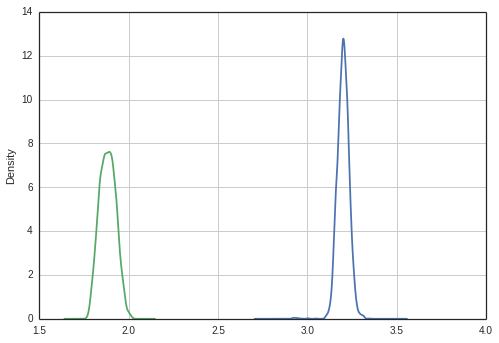

In [18]:
react = 'CS'

mcmc_reduced_dict_p1['MIC1'][react].plot(kind='density')
mcmc_reduced_dict_p1['Fc'][react].plot(kind='density')

savefig('CS.jpg')

In [19]:
#########################################################

# Perform further pruning of flux distributions
# Note: none of the remaining reactions have a significant amount of fluxes above the threshold:
#       No reactions have fluxes greater than 10 x glc uptake for > 99% of flux states
#       No reactions have fluxes greater than 20 x glc uptake

df_rxns_removed_p1 = {}

df_rxns_high_flux_remain_p1 = {}


for strain in mcmc_reduced_dict_p1.keys():

    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    

shape before pruning Fc: (5000, 2037)
shape after pruning Fc: (5000, 2004)
shape before pruning MIC1: (5000, 2037)
shape after pruning MIC1: (5000, 2000)


In [21]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['MIC1']

for i in df.index:
    if df['percent of states with flux > 10'][i] < 4900:
        print df['react_id'][i], df['percent of states with flux > 10'][i]

for i in df.index:
    if df['percent of states with flux > 10'][i] < 5000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]

ACt2rpp 4611
ASPt2pp_copy2 4311
GLYCLTt2rpp 4608
ACt2rpp 471.974936683
ASPt2pp_copy2 399.615073368
ATPM 32.1233991383
CYTBO3_4pp 21.9967063772
GLYCLTt2rpp 154.95938352
SERt2rpp 807.993458261
SUCOAS 778.87853421


In [22]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given culture conditions
# or, between culture conditions1 - culture conditions2 for a given phase
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1 = {}

for strain in mcmc_reduced_dict_p1.keys():
        if strain == 'Fc':
            continue

        print "strain:", strain
        
        flux_stats_dict_p1[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1['Fc'],mcmc_reduced_dict_p1[strain], m, 1, 2)
        

strain: MIC1


In [23]:
flux_stats_dict_p1['MIC1'][0:3]

,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,1.60e-05,1.60e-05,3.59e-07,3.10e-05,3.10e-05,5.63e-07,4.00e-04,DM_4crsol_c
1,2.13e-04,1.62e-04,1.82e-04,5.37e-04,4.30e-04,4.53e-04,4.81e-01,DM_5drib_c
2,1.43e-07,1.43e-07,3.22e-09,2.80e-07,2.78e-07,2.16e-08,4.00e-04,DM_amob_c


In [24]:
# Classify Flux shifts

flux_shift_stats_dict_p1 ={}
m_significant_shifts_dict_p1 ={}


for strain in flux_stats_dict_p1.keys():
    print "strain:", strain
    df = flux_stats_dict_p1[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict_p1[strain] = df
    m_significant_shifts_dict_p1[strain] = change


strain: MIC1
no. rxns before filtering out exchange rxns: 2135
no. rxns after filtering out exchange rxns: 1664

flux change counts:
dont shift 1624
do shift 29 



In [25]:
print m_significant_shifts_dict_p1['MIC1'].reaction.values

m_significant_shifts_dict_p1['MIC1'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'AKGDH' 'CS' 'ENO' 'FBA' 'FBA3' 'FRD2' 'FRD3' 'FUM'
 'G6PDH2r' 'GAPD' 'GLUDy' 'GND' 'ICDHyr' 'MDH' 'PDH' 'PFK' 'PFK_3' 'PGI'
 'PGK' 'PGM' 'PPC' 'PYK' 'RPI' 'SUCDi' 'TALA' 'TPI' 'PGL']


Glycolysis/Gluconeogenesis    10
Citric Acid Cycle              9
Pentose Phosphate Pathway      7
Glutamate Metabolism           1
Oxidative Phosphorylation      1
Anaplerotic Reactions          1
dtype: int64

In [26]:
# Compute Z score per reaction difference

DF_reaction_zscore_p1 = {}

for strain in mcmc_reduced_dict_p1.keys():
        if strain == 'Fc':
            continue
        
        print "strain:", strain
        
        DF_reaction_zscore_p1[strain] = get_zscore(mcmc_reduced_dict_p1['Fc'],mcmc_reduced_dict_p1[strain],m,flux_shift_stats_dict_p1,strain)
       

***PROGRESS: 2134/2135 reactions***



In [28]:
DF_reaction_zscore_p1['MIC1'][1000:1009]

,reaction,z_score
1000,GLCP2,0.12
1001,GLCRD,0.12
1002,GLCRtex,0.12
1003,GLCS1,0.12
1004,GLCUR1Ptex,0.12
1005,GLCURtex,0.12
1006,GLCabcpp,0.11
1007,GLCptspp,3.30
1008,GLCt2pp,0.00


In [29]:
for strain in DF_reaction_zscore_p1.keys():
    file1 = '%s_2h_reaction_zscore.csv'%strain
    DF_reaction_zscore_p1[strain].to_csv(file1)
    

In [30]:
# Compute met Z scores
DF_metabolite_zscore_p1 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        if strain == 'Fc':
            continue

        DF_metabolite_zscore_p1[strain] = get_met_zscore(mcmc_reduced_dict_p1['Fc'],mcmc_reduced_dict_p1[strain],m,DF_reaction_zscore_p1,strain)
        

strain: Fc
strain: MIC1


cobra/core/Species.py:93 UserWarning: deprecated, used species.reactions instead


In [32]:
DF_metabolite_zscore_p1['MIC1'][500:509]

,metabolite,num_rxns_involved,zscore
500,hdcea_c,9,0.01
501,hdceap_c,3,0.15
502,hdcoa_c,5,0.07
503,hdd2coa_c,5,0.06
504,hdeACP_c,9,0.01
505,hemeO_c,2,0.15
506,hexACP_c,3,0.12
507,hg2_c,1,0.21
508,hgmeACP_c,2,0.15


In [33]:
for strain in DF_metabolite_zscore_p1.keys():
    file1 = '%s_2h_metabolite_zscore.csv'%strain
    DF_metabolite_zscore_p1[strain].to_csv(file1)


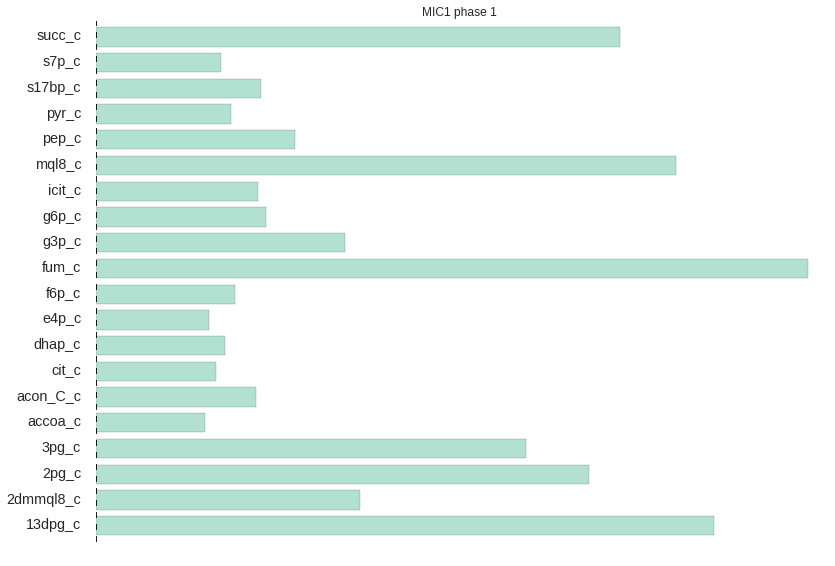

In [36]:
metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'metabolite_zscores_all_strains'
    
fig, axes = plt.subplots(nrows=1, ncols=1)  # change for adding in bis

c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

strain = "MIC1"
df =  DF_metabolite_zscore_p1[strain][~DF_metabolite_zscore_p1[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p1[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p1[strain].zscore >1.74]
    
df.zscore.plot(ax=axes, kind='barh', color=c1, title=strain + " phase 1",alpha=0.5,figsize=(5, 8))
axes.axis('off')

for i, x in enumerate(df.metabolite):
        axes.text(-0.25, i + .5, x, ha='right', fontsize='large')

####

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(8)

In [37]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

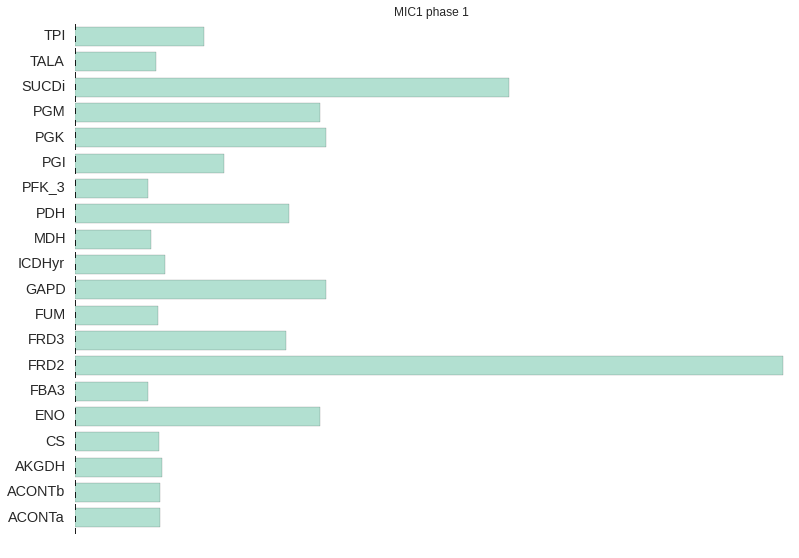

In [39]:
name_graph = 'reaction_zscores_all_strains'
    
fig, axes = plt.subplots(nrows=1, ncols=1)  # change for adding in bis

c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

strain = "MIC1"
df = DF_reaction_zscore_p1[strain][~DF_reaction_zscore_p1[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p1[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p1[strain].reaction.str.contains('pp')][DF_reaction_zscore_p1[strain].z_score > 1.74]

df.z_score.plot(ax=axes, kind='barh', color=c1, title=strain + " phase 1",alpha=0.5,figsize=(5, 7))
axes.axis('off')

for i, x in enumerate(df.reaction):
        axes.text(-0.25, i + .5, x, ha='right', fontsize='large')

####


fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(8)

In [40]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


In [41]:
for i, x in enumerate(df.reaction):
    print m.reactions.get_by_id(x).subsystem + ": " + x


Citric Acid Cycle: ACONTa
Citric Acid Cycle: ACONTb
Citric Acid Cycle: AKGDH
Citric Acid Cycle: CS
Glycolysis/Gluconeogenesis: ENO
Pentose Phosphate Pathway: FBA3
Citric Acid Cycle: FRD2
Citric Acid Cycle: FRD3
Citric Acid Cycle: FUM
Glycolysis/Gluconeogenesis: GAPD
Citric Acid Cycle: ICDHyr
Citric Acid Cycle: MDH
Glycolysis/Gluconeogenesis: PDH
Pentose Phosphate Pathway: PFK_3
Glycolysis/Gluconeogenesis: PGI
Glycolysis/Gluconeogenesis: PGK
Glycolysis/Gluconeogenesis: PGM
Oxidative Phosphorylation: SUCDi
Pentose Phosphate Pathway: TALA
Glycolysis/Gluconeogenesis: TPI


KeyError: u'no item named SUCDi'

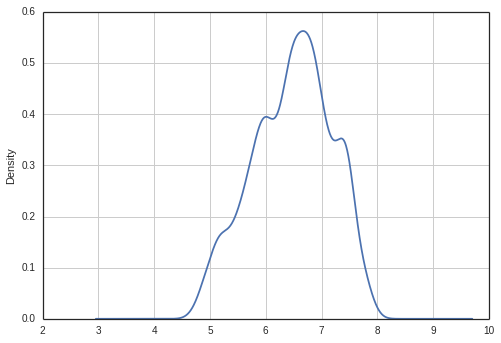

In [68]:
react = 'SUCDi'

mcmc_reduced_dict_p1['Fc'][react].plot(kind='density')
mcmc_reduced_dict_p1['MIC1'][react].plot(kind='density')


In [54]:
savefig('SUCDi.jpg')

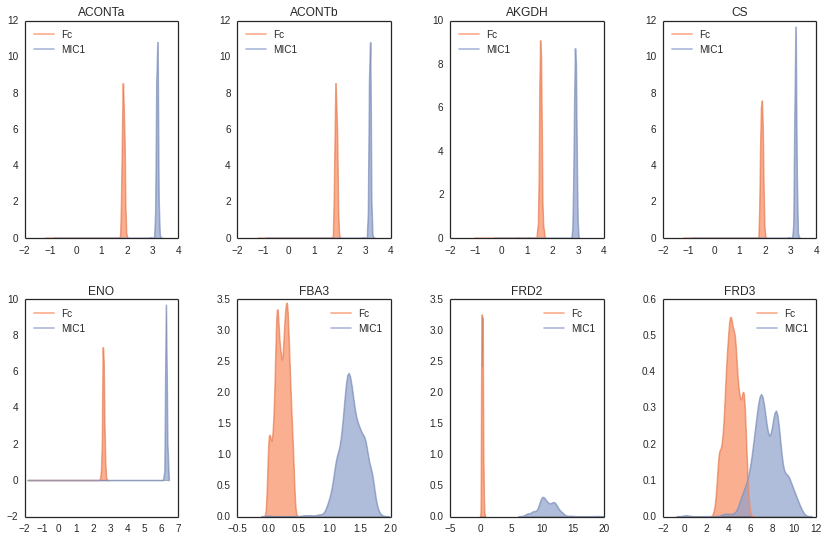

In [71]:
    name_graph = 'rxn_shifts1'
    
    fig, axes = plt.subplots(nrows=2, ncols=4)  # change for adding in bis
    
    #c1, c2, c3 = sns.color_palette("Set1", 3)
    
    c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

    df = mcmc_reduced_dict_p1
    
    keys = df.keys()
 
    labels = []
    labels.append(keys[0])
    labels.append(keys[1])

    df_tmp = df[keys[0]]
    df_tmp2 = df[keys[1]]
    
    r = 'ACONTa'
    
    #df_tmp[r].plot(kind='density',label=1, ax=axes[0,0],color=sns.color_palette()[0], title=strain)
    #df_tmp2[r].plot(kind='density',label=2,ax=axes[0,0],color=sns.color_palette()[1], title=strain)
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,0],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label= labels[1])
    axes[0,0].set_title(r)
    
    r = 'ACONTb'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,1],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,1],label= labels[1])
    axes[0,1].set_title(r)

    r = 'AKGDH'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,2],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,2],label= labels[1])
    axes[0,2].set_title(r)
    
    r = 'CS'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,3],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,3],label= labels[1])
    axes[0,3].set_title(r)
    
    r = 'ENO'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,0],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,0],label= labels[1])
    axes[1,0].set_title(r)
    
    r = 'FBA3'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,1],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,1],label= labels[1])
    axes[1,1].set_title(r)
    
    r = 'FRD2'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,2],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,2],label= labels[1])
    axes[1,2].set_title(r)
    
    r = 'FRD3'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,3],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,3],label= labels[1])
    axes[1,3].set_title(r)
    
    
    fig.tight_layout()

    fig = plt.gcf()
    fig.set_figwidth(12)
    fig.set_figheight(8)

In [72]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

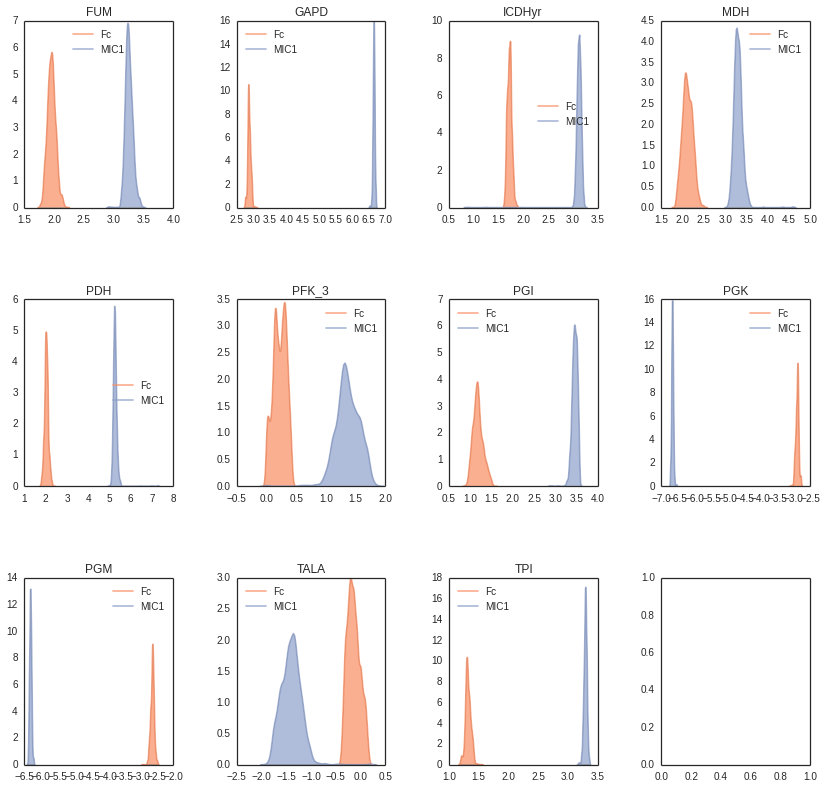

In [74]:
    name_graph = 'rxn_shifts2'
    
    fig, axes = plt.subplots(nrows=3, ncols=4)  # change for adding in bis
        
    r = 'FUM'
    
    #df_tmp[r].plot(kind='density',label=1, ax=axes[0,0],color=sns.color_palette()[0], title=strain)
    #df_tmp2[r].plot(kind='density',label=2,ax=axes[0,0],color=sns.color_palette()[1], title=strain)
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,0],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label= labels[1])
    axes[0,0].set_title(r)
    
    r = 'GAPD'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,1],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,1],label= labels[1])
    axes[0,1].set_title(r)

    r = 'ICDHyr'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,2],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,2],label= labels[1])
    axes[0,2].set_title(r)
    
    r = 'MDH'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[0,3],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,3],label= labels[1])
    axes[0,3].set_title(r)
    
    r = 'PDH'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,0],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,0],label= labels[1])
    axes[1,0].set_title(r)
    
    r = 'PFK_3'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,1],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,1],label= labels[1])
    axes[1,1].set_title(r)
    
    r = 'PGI'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,2],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,2],label= labels[1])
    axes[1,2].set_title(r)
    
    r = 'PGK'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[1,3],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,3],label= labels[1])
    axes[1,3].set_title(r)
    
    r = 'PGM'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[2,0],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,0],label= labels[1])
    axes[2,0].set_title(r)
    
    r = 'TALA'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[2,1],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,1],label= labels[1])
    axes[2,1].set_title(r)
    
    r = 'TPI'
    
    sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[2,2],label= labels[0]);
    sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,2],label= labels[1])
    axes[2,2].set_title(r)
    
    #r = 'SUCDi'
    
    #sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,1],label= labels[1])
    #sns.kdeplot(df_tmp[r], shade=True, color=c2, alpha=0.7,ax=axes[2,1],label= labels[0]);
    #axes[2,1].set_title(r)
    
    fig.tight_layout()

    fig = plt.gcf()
    fig.set_figwidth(12)
    fig.set_figheight(12)
    

In [75]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')